In [1]:
%matplotlib inline

In [4]:
import pprint

Similarity Queries with Annoy and Word2Vec
------------------------------------------

* [Annoy Approximate Nearest Neighbors Oh Yeah](https://github.com/spotify/annoy) (a spotify lib) enables similarity queries with a Word2Vec model.  

* Gensim's KNN implementation has linear complexity via brute force in the number of indexed documents, although with extremely low constant factors.

* The results are exact, which is overkill in many applications. Approximate results retrieved in sub-linear time may be enough.

In [2]:
LOGS = False
if LOGS:
    import logging
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Download Text8 corpus
------------------------

In [3]:
import gensim.downloader as api
text8_path = api.load('text8', return_path=True)
text8_path

unable to import 'smart_open.gcs', disabling that module


'/home/bjpcjp/gensim-data/text8/text8.gz'

Train Word2Vec model
---------------------
* also see `sphx_glr_auto_examples_tutorials_run_word2vec.py`.

In [5]:
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.word2vec import Text8Corpus

# Using params from Word2Vec_FastText_Comparison
params = {
    'alpha':     0.05,
    'size':    100,
    'window':    5,
    'iter':      5,
    'min_count': 5,
    'sample': 1e-4,
    'sg':        1,
    'hs':        0,
    'negative':  5
}
model = Word2Vec(Text8Corpus(text8_path), **params)
pprint.pprint(model)

Construct AnnoyIndex with model & make a similarity query
------------------------------------------------------------

* Annoy uses an instance of *AnnoyIndexer*. It takes two parameters:
    * **model**: A *Word2Vec* or *Doc2Vec* model
    * **num_trees**: A positive integer. It controls build time and index size. Larger values = more accurate results, but larger indexes. More info [here](https://github.com/spotify/annoy#how-does-it-work).

* Find the top 5 words most similar to "science" in the Text8 corpus. Call *Word2Vec.most_similar* with the *indexer* parameter to make a similarity query. ``indexer``. **Annoy** is the only supported indexer in gensim at the moment.

In [9]:
import annoy
from gensim.similarities.index import AnnoyIndexer

# 100 trees are being used in this example
annoy_index = AnnoyIndexer(model, 100)

vector                = model.wv["science"]
approximate_neighbors = model.wv.most_similar([vector], topn=11, indexer=annoy_index)
normal_neighbors      = model.wv.most_similar([vector], topn=11)

print("Approximate Neighbors")
for neighbor in approximate_neighbors:
    pprint.pprint(neighbor)

print("\nNormal (not Annoy-indexed) Neighbors")
for neighbor in normal_neighbors:
    pprint.pprint(neighbor)

Approximate Neighbors
('science', 1.0)
('actuarial', 0.610496997833252)
('cryobiology', 0.6021265387535095)
('interdisciplinary', 0.5971179902553558)
('sciences', 0.5902493000030518)
('multidisciplinary', 0.5875935554504395)
('astrobiology', 0.5875882804393768)
('popularizer', 0.5815011262893677)
('psychohistory', 0.5778442919254303)
('nanomedicine', 0.5736666321754456)
('futurists', 0.5726926624774933)

Normal (not Annoy-indexed) Neighbors
('science', 1.0)
('fiction', 0.755879282951355)
('actuarial', 0.6965747475624084)
('vernor', 0.6868565678596497)
('cryobiology', 0.6833934187889099)
('interdisciplinary', 0.6753721237182617)
('vinge', 0.6675182580947876)
('sciences', 0.6642086505889893)
('scientific', 0.6607236862182617)
('multidisciplinary', 0.6598420143127441)
('astrobiology', 0.6598330736160278)


* The closer the cosine similarity of a vector is to 1, the more similar that word is to our query (in this case, the vector for "science").

Compare to the traditional indexer
-------------------------------------

In [10]:
model.init_sims()
annoy_index = AnnoyIndexer(model, 100)

# Dry run - ensure both indices are fully in RAM
vector = model.wv.vectors_norm[0]
model.wv.most_similar([vector], topn=5, indexer=annoy_index)
model.wv.most_similar([vector], topn=5)

[('the', 0.9999999403953552),
 ('of', 0.8293697237968445),
 ('in', 0.7990010380744934),
 ('a', 0.7587085962295532),
 ('and', 0.7384316921234131)]

In [11]:
# benchmark helper - avg query time over N random queries.

import time
import numpy as np

def avg_query_time(annoy_index=None, queries=1000):

    total_time = 0
    
    for _ in range(queries):
        rand_vec    = model.wv.vectors_norm[np.random.randint(0, len(model.wv.vocab))]
        start_time  = time.process_time()

        model.wv.most_similar([rand_vec], topn=5, indexer=annoy_index)
        total_time += time.process_time() - start_time

    return total_time / queries

In [14]:
queries = 10000

gensim_time       = avg_query_time(queries=queries)
annoy_time        = avg_query_time(annoy_index, queries=queries)
speed_improvement = gensim_time / annoy_time

pprint.pprint("Gensim: {0:.5f}".format(gensim_time))
pprint.pprint("Annoy: {0:.5f}".format(annoy_time))
pprint.pprint("Annoy is {0:.2f} times faster".format(speed_improvement))

'Gensim: 0.02269'
'Annoy: 0.00029'
'Annoy is 78.47 times faster'


* Initialization time for the annoy indexer was not included in the benchmark.
* The optimal KNN depends on how many queries you need to make and the size of the corpus. 
    - Few similarity queries: the annoy initialization time will be longer than brute-force retrieval times. 
    - Many similarity queries: the annoy initialization time will be compensated by the fast retrieval times.
* Gensim's 'most_similar' method uses numpy dot product ops - Annoy's method does not. 
    - If numpy* on your machine is using one of the BLAS libraries like ATLAS or LAPACK, it'll run on multiple cores (if your machine has multicore support ). Check the [SciPy cookbook](http://scipy-cookbook.readthedocs.io/items/ParallelProgramming.html) for more details.

Persisting indices to disk
-----------------------------
* Create two files on disk, *fname* and *fname.d*. Both are needed to correctly restore all attributes. Before loading an index, you need to create an empty AnnoyIndexer object.

In [15]:
fname = '/tmp/mymodel.index'

# Persist index to disk
annoy_index.save(fname)

# Load index back
import os.path
if os.path.exists(fname):
    annoy_index2 = AnnoyIndexer()
    annoy_index2.load(fname)
    annoy_index2.model = model

# Results should be identical to above
vector                 = model.wv["science"]
approximate_neighbors2 = model.wv.most_similar([vector], topn=11, indexer=annoy_index2)
for neighbor in approximate_neighbors2:
    pprint.pprint(neighbor)
    
assert approximate_neighbors == approximate_neighbors2

('science', 1.0)
('actuarial', 0.610496997833252)
('cryobiology', 0.6021265387535095)
('interdisciplinary', 0.5971179902553558)
('sciences', 0.5902493000030518)
('multidisciplinary', 0.5875935554504395)
('astrobiology', 0.5875882804393768)
('popularizer', 0.5815011262893677)
('psychohistory', 0.5778442919254303)
('nanomedicine', 0.5736666321754456)
('futurists', 0.5726926624774933)


/home/bjpcjp/.local/lib/python3.6/site-packages/gensim/similarities/index.py:159: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  self.index = AnnoyIndex(d['f'])


* Be sure to use the same model at load that was used originally, otherwise you will get unexpected behaviors.

Save memory via memory-mapping indices saved to disk
----------------------------------------------------

* Annoy can accept indices that are memory-mapped from disk. It saves memory when the same index is used by several processes.
* Below are two snippets of code. First one has a separate index for each process. The second snipped shares the index between two processes via memory-mapping. The second example uses less total RAM as it is shared.

In [16]:
# Remove verbosity from code below (if logging active)
if LOGS:
    logging.disable(logging.CRITICAL)

from multiprocessing import Process
import os
import psutil

* Bad example: two processes load a Word2vec model from disk and create their own Annoy indices.

In [17]:
model.save('/tmp/mymodel.pkl')

def f(process_id):
    print('Process Id: {}'.format(os.getpid()))
    
    process               = psutil.Process(os.getpid())
    new_model             = Word2Vec.load('/tmp/mymodel.pkl')
    vector                = new_model.wv["science"]
    annoy_index           = AnnoyIndexer(new_model,100)
    approximate_neighbors = new_model.wv.most_similar([vector], topn=5, indexer=annoy_index)
    print('\nMemory used by process {}: {}\n---'.format(os.getpid(), process.memory_info()))

# Creating and running two parallel process to share the same index file.
p1 = Process(target=f, args=('1',)); p1.start(); p1.join()
p2 = Process(target=f, args=('2',)); p2.start(); p2.join()

Process Id: 26557


/home/bjpcjp/.local/lib/python3.6/site-packages/gensim/similarities/index.py:184: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  index = AnnoyIndex(num_features)



Memory used by process 26557: pmem(rss=558882816, vms=2195030016, shared=12742656, text=4083712, lib=0, data=851476480, dirty=0)
---
Process Id: 26567


/home/bjpcjp/.local/lib/python3.6/site-packages/gensim/similarities/index.py:184: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  index = AnnoyIndex(num_features)



Memory used by process 26567: pmem(rss=558931968, vms=2195030016, shared=12742656, text=4083712, lib=0, data=851591168, dirty=0)
---


* Better example: two processes load a Word2vec model and index from disk and memory-map the index.

In [19]:
model.save('/tmp/mymodel.pkl')

def f(process_id):
    print('Process Id: {}'.format(os.getpid()))
    
    process     = psutil.Process(os.getpid())
    new_model   = Word2Vec.load('/tmp/mymodel.pkl')
    vector      = new_model.wv["science"]
    annoy_index = AnnoyIndexer()

    annoy_index.load('/tmp/mymodel.index')
    
    annoy_index.model     = new_model
    approximate_neighbors = new_model.wv.most_similar([vector], topn=5, indexer=annoy_index)

    print('\nMemory used by process {}: {}\n---'.format(os.getpid(), process.memory_info()))

# Creating and running two parallel process to share the same index file.

p1 = Process(target=f, args=('1',)); p1.start(); p1.join()
p2 = Process(target=f, args=('2',)); p2.start(); p2.join()

Process Id: 26704


/home/bjpcjp/.local/lib/python3.6/site-packages/gensim/similarities/index.py:159: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  self.index = AnnoyIndex(d['f'])



Memory used by process 26704: pmem(rss=429486080, vms=2173390848, shared=34549760, text=4083712, lib=0, data=700276736, dirty=0)
---
Process Id: 26713


/home/bjpcjp/.local/lib/python3.6/site-packages/gensim/similarities/index.py:159: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  self.index = AnnoyIndex(d['f'])



Memory used by process 26713: pmem(rss=429514752, vms=2173390848, shared=34549760, text=4083712, lib=0, data=700309504, dirty=0)
---


Evaluate *num_trees* for initialization time and accuracy
---------------------------------------------------------

In [20]:
import matplotlib.pyplot as plt

Build dataset of Initialization times and accuracy measures:




In [21]:
exact_results = [element[0] for element in model.wv.most_similar([model.wv.vectors_norm[0]], topn=100)]

x_values = []
y_values_init = []
y_values_accuracy = []

for x in range(1, 300, 10):
    x_values.append(x)
    start_time  = time.time()
    annoy_index = AnnoyIndexer(model, x)
    y_values_init.append(time.time() - start_time)
    
    approximate_results = model.wv.most_similar([model.wv.vectors_norm[0]], topn=100, indexer=annoy_index)
    top_words           = [result[0] for result in approximate_results]
    
    y_values_accuracy.append(len(set(top_words).intersection(exact_results)))

/home/bjpcjp/.local/lib/python3.6/site-packages/gensim/similarities/index.py:184: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  index = AnnoyIndex(num_features)


Plot results:



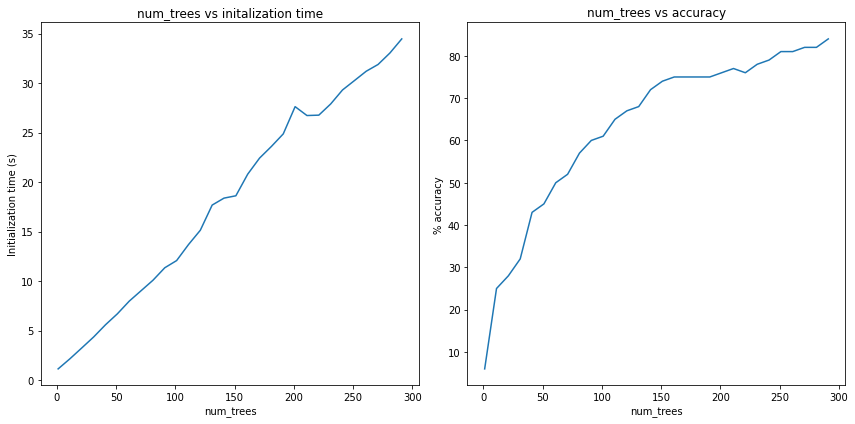

In [16]:
plt.figure(1, figsize=(12, 6))
plt.subplot(121)
plt.plot(x_values, y_values_init)
plt.title("num_trees vs initalization time")
plt.ylabel("Initialization time (s)")
plt.xlabel("num_trees")
plt.subplot(122)
plt.plot(x_values, y_values_accuracy)
plt.title("num_trees vs accuracy")
plt.ylabel("% accuracy")
plt.xlabel("num_trees")
plt.tight_layout()
plt.show()

### Observations:

* Initialization time of the annoy indexer increases linearly with num_trees. Initialization time will vary from corpus to corpus.
* Accuracy seems logarithmically related to num_trees. We see an improvement in accuracy with more trees, but the relationship is nonlinear. 

### Working with Google word2vec files

* The model can be exported to a word2vec C format. (There are binary and plain text formats; both can be read with a variety of other software, or imported back into gensim as a *KeyedVectors* object.)

In [22]:
import pprint

In [24]:
# To export our model as text
model.wv.save_word2vec_format('/tmp/vectors.txt', binary=False)

from smart_open import open

# View the first 3 lines of the exported file
# first line: total #entries & vector dimension count. 
# next lines: key (string) followed by its vector.

with open('/tmp/vectors.txt') as myfile:
    for i in range(3):
        pprint.pprint(myfile.readline().strip())

# import word2vec text model
wv = KeyedVectors.load_word2vec_format('/tmp/vectors.txt', binary=False)

# export model as binary
model.wv.save_word2vec_format('/tmp/vectors.bin', binary=True)

# import word2vec binary model
wv = KeyedVectors.load_word2vec_format('/tmp/vectors.bin', binary=True)

# create and save Annoy Index from a loaded `KeyedVectors` object (with 100 trees)
annoy_index = AnnoyIndexer(wv, 100)
annoy_index.save('/tmp/mymodel.index')

# Load and test the saved word vectors and saved annoy index
wv = KeyedVectors.load_word2vec_format('/tmp/vectors.bin', binary=True)
annoy_index = AnnoyIndexer()
annoy_index.load('/tmp/mymodel.index')
annoy_index.model = wv

vector = wv["cat"]
approximate_neighbors = wv.most_similar([vector], topn=11, indexer=annoy_index)

# Print approximate_neighbors and corresponding cosine similarity values
pprint.pprint("Approximate Neighbors")

for neighbor in approximate_neighbors:
    pprint.pprint(neighbor)

normal_neighbors = wv.most_similar([vector], topn=11)
pprint.pprint("\nNormal (not Annoy-indexed) Neighbors")
for neighbor in normal_neighbors:
    pprint.pprint(neighbor)

'71290 100'
('the -0.06319707 0.039195236 0.07588886 0.4001127 -0.11037322 -0.107520714 '
 '0.13087319 -0.20622094 -0.0949448 -0.08399528 0.19712624 0.13627666 '
 '-0.02414426 0.078349985 -0.07241503 0.039491024 0.016215933 -0.030245265 '
 '-0.10123521 0.31701308 -0.13136622 0.34437454 0.060374323 0.31825018 '
 '0.14200555 -0.1566122 0.07745484 -0.11334791 -0.03250157 -0.11339325 '
 '0.0064096362 -0.07260254 0.13012147 0.058228973 0.14634727 -0.06686603 '
 '0.065946944 0.029342297 -0.06659591 -0.03133354 0.078267075 -0.16899376 '
 '0.18725447 0.13923602 0.061894465 -0.042796716 -0.27118808 -0.08819458 '
 '0.16076052 0.16670893 0.081136055 -0.18391502 0.17287001 0.07644524 '
 '0.027009718 -0.06526753 0.2662025 0.18883434 -0.079988696 -0.1593661 '
 '-0.1442297 -0.0799088 -0.22751018 -0.20122932 0.04568328 -0.0910776 '
 '0.18464975 -0.021864004 0.084170915 -0.08863863 0.25164923 -0.2646064 '
 '-0.047189914 0.19173446 0.09403665 0.07390129 -0.13470581 0.18706603 '
 '-0.22928306 0.002757942

/home/bjpcjp/.local/lib/python3.6/site-packages/gensim/similarities/index.py:184: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  index = AnnoyIndex(num_features)


'Approximate Neighbors'
('cat', 1.0)
('leopardus', 0.5960615575313568)
('prionailurus', 0.5871723294258118)
('bird', 0.5858444571495056)
('pug', 0.585036963224411)
('hyena', 0.576640397310257)
('ferret', 0.5735411643981934)
('sighthound', 0.5715452134609222)
('guppy', 0.5678088963031769)
('parrot', 0.5659262835979462)
('dog', 0.5657534897327423)
'\nNormal (not Annoy-indexed) Neighbors'
('cat', 1.0)
('cats', 0.6808634996414185)
('leopardus', 0.6736674308776855)
('felis', 0.6686286330223083)
('meow', 0.6680138111114502)
('prionailurus', 0.6591466069221497)
('bird', 0.6569503545761108)
('pug', 0.6556112766265869)
('hyena', 0.6415332555770874)
('ferret', 0.6362656950950623)
('poodle', 0.6361774802207947)


/home/bjpcjp/.local/lib/python3.6/site-packages/gensim/similarities/index.py:159: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  self.index = AnnoyIndex(d['f'])
